In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from scipy import stats
from sklearn import preprocessing
import networkx as nx
from networkx.algorithms.components import node_connected_component as ncc


from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal



#1608 da escludere always
#1065 mape = 9
skus = [2705]#,1065,1206,1058,549,688]
#skus = [2689, 1027, 2696, 2698, 1035,  144, 2704, 1554, 2705, 2707, 2711, 2712, 1051, 2718,
#  546, 1058,  549, 1065,  554,  686,  688, 1206, 2360, 2365, 1472, 1600, 1603, 1732,
#  2249, 1356, 1618, 1365, 1371, 2396, 1633, 2401, 2410, 1516, 2678, 2681, 2682,
# 2683]
SplitTestData = "2018-12"
SplitValData = "2018-09"

import warnings
warnings.filterwarnings("ignore")

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,date):
    X_te = X[date:]
    y_te = y[date:]
    X_tr = X[:date]
    y_tr = y[:date]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction #0.1*pred_test +0.2*pred_test_cat + 0.7*pred_test_xgb
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    #plt.ylim([200,330])
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()
    


# SELEZIONA COME NORMALIZZARE:

In [ ]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature):
    size = len(feature)
    #return min_max_scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    return quantile_transformer.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
    
def unscale(scaled, original):
    size2 = len(scaled)
    size1 = len(original)
    #return min_max_scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]
    return quantile_transformer.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [3]:
def create_features(df, label=None):
    df2 = pd.DataFrame(columns= df.columns)

    for sku in df['sku'].unique():
        sales_sku = df.loc[df['sku'] == sku]
        sales_sku["log_price"] = np.log(sales_sku["price"])
        sales_sku['log_sales'] = scale(sales_sku['sales w-1'])
        sales_sku["promo"] = scale(sales_sku["volume_on_promo w-1"])
        sales_sku["rolling2"] = sales_sku["log_sales"].rolling(3).mean()
        sales_sku["rolling3"] = sales_sku["log_sales"].rolling(2).mean()
        sales_sku['diff1'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(1)))
        sales_sku['diff2'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(2)))
        sales_sku['diff3'] = -(scale(sales_sku['sales w-1']) - scale(sales_sku['sales w-1'].shift(3)))
        sales_sku['pdiff1'] = -(sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1))/sales_sku['sales w-1']
        sales_sku['price_diff1'] = -(sales_sku['log_price'] - sales_sku['log_price'].shift(1))

        
        df2 = pd.concat((df2, sales_sku), axis = 0)

    df = df2
 
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear/7
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df["sku"] = df["sku"].apply(lambda x: int(x))
    
    df = df.dropna()
    df = df.set_index("date")

    X = df[['quarter','month','year','price_diff1',
           'dayofyear','dayofmonth','weekofyear',"log_sales",
            'promo','diff1','diff2','pdiff1','log_price',"rolling2","rolling3","sku"]]
    
    if label:
        y = df[label]
        return X, y
    return X

In [4]:
# Read train and test files
train_df = pd.read_csv('../data/raw/train.csv')
#test_df = pd.read_csv('../data/raw/x_test.csv')

train_df = train_df.drop(["target"],axis = 1)

#all_df = pd.concat([train_df,test_df])
all_df = train_df

all_df = all_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
#all_df = all_df.loc[all_df["scope"] == 1]
all_df = all_df.drop(["scope"],axis = 1)

all_df.date = all_df.date.apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
all_df.head()

,date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1
1,2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0
2,2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0
3,2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0
4,2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0
5,2017-01-14,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.058565,25971.0


In [5]:
#crea la colonna target
all_df = all_df.set_index("date")

t2 = pd.DataFrame(columns= all_df.columns)

originals = pd.DataFrame(columns = ["target","sku"])

for sku in all_df['sku'].unique():
    
    sales_sku = all_df.loc[all_df['sku'] == sku]
    #sales_sku = sales.set_index(['Week'])
    if sku in skus:
        new = pd.DataFrame({"target":sales_sku["sales w-1"].shift(-1)[:-1],"sku":sales_sku["sku"][:-1]},index = sales_sku.index[:-1])
        originals = pd.concat([originals,new])
    sales_sku['target'] = np.append(scale(sales_sku["sales w-1"].shift(-1)[:-1]),0.0)
    sales_sku = sales_sku[:-1]
    t2 = pd.concat((t2, sales_sku), axis = 0)

t2.head()

,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,target
2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0.752816
2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0.685504
2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0.425612
2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0.866865
2017-01-14,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.058565,25971.0,0.897402


In [6]:
X_train, y_train = create_features(t2, label='target')
X_train.head()

,quarter,month,year,price_diff1,dayofyear,dayofmonth,weekofyear,log_sales,promo,diff1,diff2,pdiff1,log_price,rolling2,rolling3,sku
date,,,,,,,,,,,,,,,,
2017-01-07,1,1,2017,-0.0,1.0,7,1,0.425612,0.298120,0.259892,0.327204,0.338528,0.14842,0.621311,0.555558,2689
2017-01-14,1,1,2017,-0.0,2.0,14,2,0.866865,0.290586,-0.441253,-0.181361,-0.364984,0.14842,0.659327,0.646239,2689
2017-01-21,1,1,2017,-0.0,3.0,21,3,0.897402,0.418774,-0.030537,-0.471790,-0.024637,0.14842,0.729960,0.882134,2689
2017-01-28,1,1,2017,-0.0,4.0,28,4,0.873894,0.224485,0.023508,-0.007029,0.019332,0.14842,0.879387,0.885648,2689
2017-02-04,1,2,2017,-0.0,5.0,4,5,0.884880,0.221652,-0.010986,0.012522,-0.008954,0.14842,0.885392,0.879387,2689


In [7]:
targets = pd.DataFrame()
for sku in t2.sku.unique():
    targets[sku] = t2.loc[t2['sku'] == sku]["target"]
targets.head()

,2689,1027,2696,2698,1035,144,2704,1554,2705,2707,...,1371,2396,1633,2401,2410,1516,2678,2681,2682,2683
2016-12-17,0.752816,0.084126,0.305262,0.077675,0.093928,0.486490,0.528132,0.267033,0.611076,0.441564,...,0.347097,0.079952,0.374038,0.642186,0.562241,0.209791,0.319032,0.332723,0.257379,0.376992
2016-12-24,0.685504,0.068186,0.279428,0.076628,0.089946,0.407090,0.729906,0.247373,0.608919,0.637479,...,0.270542,0.054262,0.335511,0.565512,0.521454,0.194327,0.274314,0.283203,0.224918,0.345721
2016-12-31,0.425612,0.000000,0.004407,0.000000,0.014562,0.053880,0.194152,0.000000,0.269251,0.263098,...,0.064536,0.000000,0.000000,0.332343,0.218108,0.000000,0.102383,0.187386,0.044872,0.172747
2017-01-07,0.866865,0.102521,0.394020,0.130606,0.106614,0.112516,0.664149,0.408828,0.855275,0.648379,...,0.761234,0.251337,0.345402,0.260606,0.175007,0.415695,0.329101,0.364662,0.383404,0.460760
2017-01-14,0.897402,0.130624,0.407920,0.137291,0.140569,0.110378,0.685698,0.470299,0.967073,0.695594,...,0.806488,0.352417,0.445781,0.195421,0.149359,0.466716,0.310964,0.372573,0.384040,0.445653


In [20]:
def takeCorr(elem):
    return elem[1]

correlations = []
for c1 in targets.columns:
    for c2 in targets.columns:
        if c1 < c2:
            if targets[c1].corr(targets[c2]) > 0.70:
                correlations.append([(c1,c2),targets[c1].corr(targets[c2])])
correlations.sort(reverse=True,key=takeCorr)
print(correlations)

[[(688, 1058), 0.9904694375848339], [(546, 549), 0.990272391439303], [(688, 1206), 0.9882087824643105], [(549, 1058), 0.9862352081585344], [(546, 554), 0.9858608280549149], [(144, 686), 0.9856338155782393], [(549, 554), 0.9850640319647548], [(549, 1027), 0.9850222812104157], [(1058, 1065), 0.9830268508953867], [(549, 688), 0.982340868498194], [(549, 1065), 0.9821071931174429], [(546, 1027), 0.9820618129348663], [(1058, 1206), 0.9793340509753644], [(549, 1035), 0.9787798073160289], [(1035, 1206), 0.9784967769660351], [(546, 1058), 0.9771255728103382], [(554, 1065), 0.9763403192811992], [(688, 1027), 0.9762525378519532], [(1027, 1058), 0.976017958689288], [(688, 1065), 0.9748902877196934], [(546, 1065), 0.9747466096087891], [(549, 1206), 0.9738349336274766], [(2249, 2401), 0.9735797684840769], [(688, 1035), 0.9701434411904105], [(1027, 1035), 0.9687014604381593], [(1027, 1065), 0.9677299424723537], [(1027, 1206), 0.9677235444850666], [(554, 1027), 0.9675108833137975], [(546, 688), 0.9672

In [21]:
G = nx.Graph()
for e in range(0,len(correlations)):
    G.add_edge(correlations[e][0][0],correlations[e][0][1])
print(len(G))

34


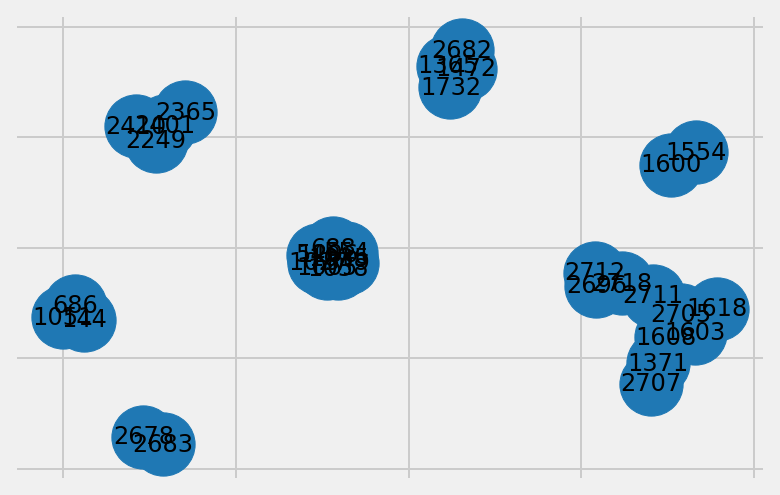

In [27]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size = 1000)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='r')
nx.draw_networkx_labels(G, pos)
plt.show()

In [23]:
groups = []


for couple, corr in correlations:
    found = False
    for g in groups:
        
        if couple in g:
            if not couple[1] in g:
                g.append(couple[1])
            found = True
        elif couple[1] in g:
            if not couple[0] in g:
                g.append(couple[0])
            found = True
        
    if not found :
        groups.append([couple[0],couple[1]])
print(len(groups))
for i in range(0,len(groups)):
    for g in groups[i+1:]:
        for e in groups[i]:
            if e in g:
                groups[i].extend(g)
                groups[i] = list(dict.fromkeys(groups[i]))
                groups.remove(g)
                break
        
(groups)
    

20


[[688, 1058, 549, 546, 1027, 554, 1035, 1206, 1065],
 [144, 686, 1051],
 [2249, 2401, 2365, 2410],
 [2678, 2683],
 [1365, 1732, 1472, 2682],
 [1603, 2705, 1608, 1618, 2696, 2718, 2711, 2712, 1371, 2707],
 [1554, 1600]]

[[688, 1058, 549, 546, 1027, 554], [1035, 1206], [144, 686], [2249, 2401]] 